Quantum State Preparation - QSP

In [23]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister 
from qiskit.primitives import StatevectorSampler as Sampler
from qiskit import QuantumCircuit
from qiskit.circuit.library import UnitaryGate
from scipy.linalg import svd
import numpy as np
import random

In [63]:
# Função para preparar o estado de modo recursivo
def prepare_state(circuit, state, qubits):

    n = len(qubits)  # Número de qubits

    # Caso base: Se tivermos apenas dois qubits, usamos initialize.
    if n == 1:
        circuit.initialize(state, qubits)
        return

    k = n // 2  # Dividir o número de qubits pela metade

    dim1 = 2 ** k
    dim2 = 2 ** (n - k)
    state = state.reshape((dim1, dim2))  # Reshape para matriz retangular

    # Decomposição SVD para obter coeficientes de Schmidt e unitários
    U, singular_values, V_dag = svd(state)
    singular_values = singular_values / np.linalg.norm(singular_values)  # Normalizar

    # Prepara o estado no primeiro subespaço
    prepare_state(circuit, singular_values, qubits[:k])

    # Fase 2: Aplicar CNOT entre os dois subespaços
    for i in range(k):
        circuit.cx(qubits[i], qubits[i + k])

    # Fase 3: Aplicar o unitário no primeiro subespaço
    U_gate = UnitaryGate(U, label="U")
    circuit.append(U_gate, qubits[:k])

    # Fase 4: Aplicar o unitário no segundo subespaço
    V_gate = UnitaryGate(V_dag.T.conj(), label="V†")
    circuit.append(V_gate, qubits[k:])

In [64]:
# Função para preparar um estado quântico arbitrário
def prepare_arbitrary_state(n, state):

    if len(state) != 2**n:
        raise ValueError("O vetor do estado deve ter dimensão 2^n.")

    # Inicializar o circuito
    qc = QuantumCircuit(n)

    # Preparar o estado
    prepare_state(qc, state, list(range(n)))

    return qc

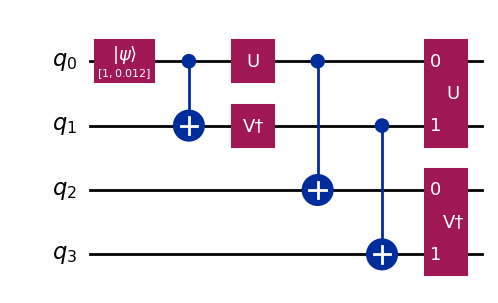

In [69]:
n_qubits = 4  # Teste com número ímpar
target_state = np.random.rand(2**n_qubits) + 1j * np.random.rand(2**n_qubits)  # Estado aleatório
target_state = target_state / np.linalg.norm(target_state)  # Normalizar

# Gerar o circuito
circuit = prepare_arbitrary_state(n_qubits, target_state)

# Exibir o circuito
circuit.draw('mpl')

In [ ]:
measure = circuit.copy()

# Simular o circuito
measure.measure_all()

sampler = Sampler()

job = sampler.run([measure])
result = job.result()
print(f" > Counts: {result[0].data.meas.get_counts()}")

 > Counts: {'001001110': 1024}
PrimitiveResult([SamplerPubResult(data=DataBin(c=BitArray(<shape=(), num_shots=1024, num_bits=1>), meas=BitArray(<shape=(), num_shots=1024, num_bits=9>)), metadata={'shots': 1024, 'circuit_metadata': {}})], metadata={'version': 2})


Quantum Error Correction - QEC


Shor Code
--------------

 Uncorrected bit flip and phase error
--------------------------------------
{'1': 1000}

Shor code with bit flip and phase error
----------------------------------------
{'0': 1000}


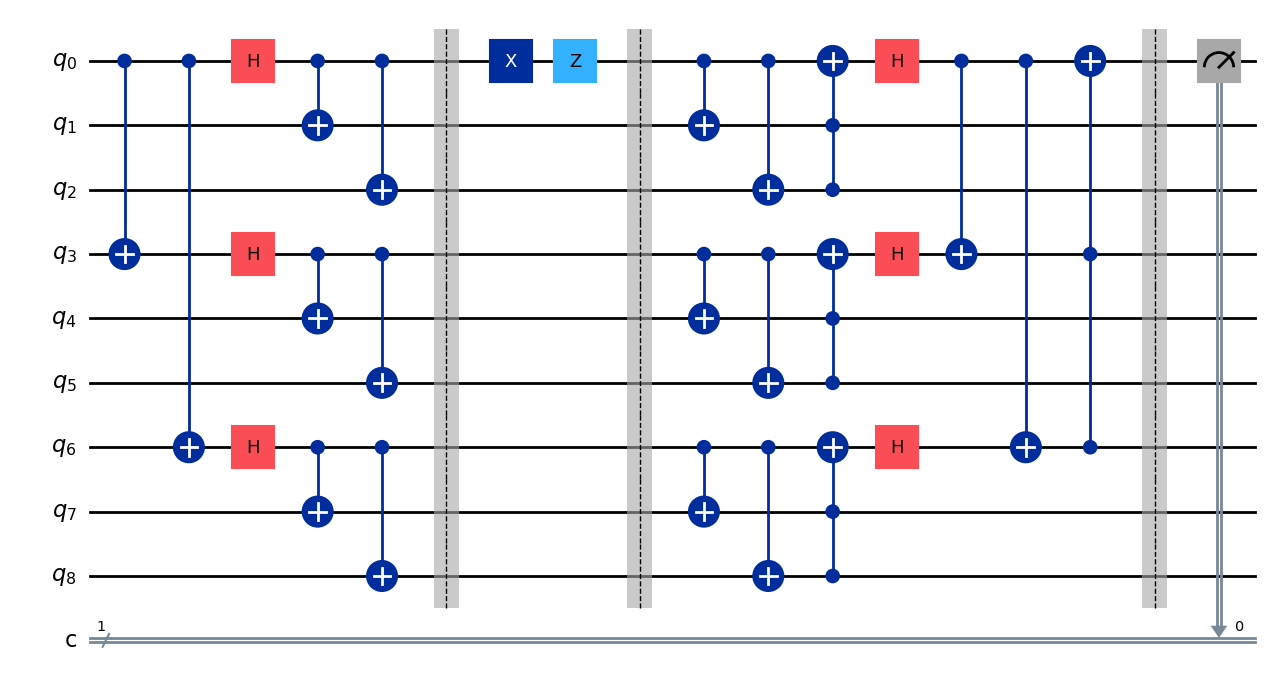

In [95]:
print('\nShor Code')
print('--------------')

sampler = Sampler()

q = QuantumRegister(1,'q')
c = ClassicalRegister(1,'c')

circuit = QuantumCircuit(q,c)

circuit.h(q[0])

####error here############
circuit.x(q[0])#Bit flip error
circuit.z(q[0])#Phase flip error
############################

circuit.h(q[0])

circuit.barrier(q)

circuit.measure(0,0)

job = sampler.run([circuit], shots=1000)

result = job.result()

print("\n Uncorrected bit flip and phase error")
print("--------------------------------------")

print(result[0].data.c.get_counts())

#####Shor code starts here ########
q = QuantumRegister(9,'q')
c = ClassicalRegister(1,'c')

circuit = QuantumCircuit(q,c)

circuit.cx(q[0],q[3])
circuit.cx(q[0],q[6])

circuit.h(q[0])
circuit.h(q[3])
circuit.h(q[6])

circuit.cx(q[0],q[1])
circuit.cx(q[3],q[4])
circuit.cx(q[6],q[7])

circuit.cx(q[0],q[2])
circuit.cx(q[3],q[5])
circuit.cx(q[6],q[8])

circuit.barrier(q)

####error here############
circuit.x(q[0])#Bit flip error
circuit.z(q[0])#Phase flip error
############################

circuit.barrier(q)
circuit.cx(q[0],q[1])
circuit.cx(q[3],q[4])
circuit.cx(q[6],q[7])

circuit.cx(q[0],q[2])
circuit.cx(q[3],q[5])
circuit.cx(q[6],q[8])

circuit.ccx(q[1],q[2],q[0])
circuit.ccx(q[4],q[5],q[3])
circuit.ccx(q[8],q[7],q[6])

circuit.h(q[0])
circuit.h(q[3])
circuit.h(q[6])

circuit.cx(q[0],q[3])
circuit.cx(q[0],q[6])
circuit.ccx(q[6],q[3],q[0])

circuit.barrier(q)

circuit.measure(0,0)

job = sampler.run([circuit], shots=1000)

result = job.result()

print("\nShor code with bit flip and phase error")
print("----------------------------------------")
print(result[0].data.c.get_counts())

circuit.draw(output='mpl') #Draws an image of the circuit

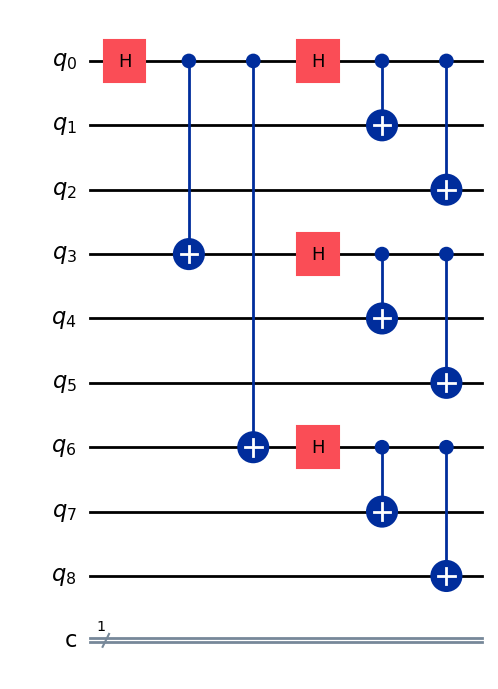

In [28]:
def encode_qubit():
    qc = QuantumCircuit(9, 1)
    qc.h(0)
    qc.cx(0, 3)
    qc.cx(0, 6)
    qc.h([0, 3, 6])
    qc.cx(0, 1)
    qc.cx(0, 2)
    qc.cx(3, 4)
    qc.cx(3, 5)
    qc.cx(6, 7)
    qc.cx(6, 8)
    return qc

qc_encode = encode_qubit()
qc_encode.draw(output='mpl')

In [29]:
# Simulação de correção de erro com Sampler
def simulate_error_correction():
    qc = encode_qubit()
    error_qubit = random.randint(0, 8)
    error_type = random.choice(['x', 'z'])
    
    if error_type == 'x':
        qc.x(error_qubit)
    else:
        qc.z(error_qubit)
    
    qc = extract_syndrome(qc, 0)
    qc = correct_error(qc, 0)
    
    #qc.measure_all()

    # Usando o Sampler para executar o circuito
    #sampler = Sampler()
    #job = sampler.run([qc])
    #result = job.result()
    
    # Exibindo os resultados
    #print(f" > Counts: {result[0].data.meas.get_counts()}")

simulate_error_correction()

TypeError: extract_syndrome() missing 1 required positional argument: 'syndrome_qubits'

In [8]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.primitives import Sampler
import random
import numpy as np

# Função para preparar o estado de modo recursivo
def prepare_state(circuit, state, qubits):
    n = len(qubits)  # Número de qubits

    # Caso base: Se tivermos apenas um qubit, usamos initialize.
    if n == 1:
        circuit.initialize(state, qubits)
        return

    # Divisão do espaço de Hilbert
    if n % 2 == 0:  # Número par de qubits
        k = n // 2
    else:  # Número ímpar de qubits
        k = n // 2  # Particiona em k e k+1 qubits

    dim1 = 2 ** k
    dim2 = 2 ** (n - k)
    state = state.reshape((dim1, dim2))  # Reshape para matriz retangular

    # Decomposição SVD para obter coeficientes de Schmidt e unitários
    U, singular_values, V_dag = np.linalg.svd(state)
    singular_values = singular_values / np.linalg.norm(singular_values)  # Normalizar

    # Prepara o estado no primeiro subespaço
    prepare_state(circuit, singular_values, qubits[:k])

    # Fase 2: Aplicar CNOT entre os dois subespaços
    for i in range(k):
        circuit.cx(qubits[i], qubits[i + k])

    # Fase 3: Aplicar o unitário no primeiro subespaço
    U_gate = UnitaryGate(U, label="U")
    circuit.append(U_gate, qubits[:k])

    # Fase 4: Aplicar o unitário no segundo subespaço
    V_gate = UnitaryGate(V_dag.T.conj(), label="V†")
    circuit.append(V_gate, qubits[k:])

# Função para preparar um estado quântico arbitrário
def prepare_arbitrary_state(n, state):
    if len(state) != 2**n:
        raise ValueError("O vetor do estado deve ter dimensão 2^n.")

    # Inicializar o circuito
    qc = QuantumCircuit(n)

    # Preparar o estado
    prepare_state(qc, state, list(range(n)))

    return qc

# Função para extrair a síndrome
def extract_syndrome(qc, logical_qubit, syndrome_qubits):
    # Extraindo a síndrome para erros de bit-flip
    qc.cx(logical_qubit, syndrome_qubits[0])
    qc.cx(logical_qubit + 1, syndrome_qubits[1])
    qc.cx(logical_qubit + 2, syndrome_qubits[2])

    # Extraindo a síndrome para erros de phase-flip
    qc.h(logical_qubit)
    qc.h(logical_qubit + 1)
    qc.h(logical_qubit + 2)
    qc.cx(logical_qubit, syndrome_qubits[3])
    qc.cx(logical_qubit + 1, syndrome_qubits[4])
    qc.cx(logical_qubit + 2, syndrome_qubits[5])
    qc.h(logical_qubit)
    qc.h(logical_qubit + 1)
    qc.h(logical_qubit + 2)

    return qc

# Função para corrigir erros
def correct_error(qc, logical_qubit, syndrome_qubits):
    # Corrigindo erros de bit-flip
    qc.x(logical_qubit).c_if(syndrome_qubits[0], 1)
    qc.x(logical_qubit + 1).c_if(syndrome_qubits[1], 1)
    qc.x(logical_qubit + 2).c_if(syndrome_qubits[2], 1)

    # Corrigindo erros de phase-flip
    qc.z(logical_qubit).c_if(syndrome_qubits[3], 1)
    qc.z(logical_qubit + 1).c_if(syndrome_qubits[4], 1)
    qc.z(logical_qubit + 2).c_if(syndrome_qubits[5], 1)

    return qc

# Simulação de correção de erro com Sampler
def simulate_error_correction():
    n_qubits = 3  # Número de qubits lógicos
    target_state = np.random.rand(2**n_qubits) + 1j * np.random.rand(2**n_qubits)  # Estado aleatório
    target_state = target_state / np.linalg.norm(target_state)  # Normalizar

    # Preparar o estado
    qc = prepare_arbitrary_state(n_qubits, target_state)

    # Adicionar qubits de síndrome
    syndrome_qubits = list(range(n_qubits, n_qubits + 6))
    syndrome_register = QuantumRegister(6, 'syndrome')
    qc.add_register(syndrome_register)  # Adiciona 6 qubits para as síndromes

    # Aplicar erro aleatório
    error_qubit = random.randint(0, n_qubits - 1)
    error_type = random.choice(['x', 'z'])
    if error_type == 'x':
        qc.x(error_qubit)
    else:
        qc.z(error_qubit)

    # Extrair síndrome
    qc = extract_syndrome(qc, 0, syndrome_qubits)

    # Corrigir erro
    qc = correct_error(qc, 0, syndrome_qubits)

    # Usar o Sampler para executar o circuito
    sampler = Sampler()
    job = sampler.run([qc])
    result = job.result()

    # Exibir os resultados
    print(f" > Probabilidades: {result[0].data.meas.get_counts()}")

# Executar simulação de correção de erro
simulate_error_correction()

CircuitError: 'Classical bit index 3 is out-of-range.'